In [10]:
"""

Identify plant based on image segmentation -- feature extraction

"""

import geopandas as gpd
import rasterio
try:
    from osgeo import gdal, osr
except:
    pass
import numpy as np
import matplotlib.pyplot as plt

import skimage
print(skimage.__version__)

0.13.0


In [11]:
# def fnames
import os
dpath = 'data/'
trainf = os.path.join(dpath, 'train.tif')
testf = os.path.join(dpath, 'test.tif')
truthf = os.path.join(dpath, 'train_ground_truth.shp')

assert os.path.isfile(trainf)
assert os.path.isfile(testf)
assert os.path.isfile(truthf)

In [12]:
truth = gpd.read_file(truthf)

datasetTrain = rasterio.open(trainf)
print(datasetTrain.meta)

datasetTest = rasterio.open(testf)
print(datasetTest.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6735, 'height': 5214, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(7.23197880395e-08, 0.0, -89.8129073071484,
       0.0, -7.23197880395e-08, 35.12562160893812)}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6720, 'height': 4865, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(7.23197880395e-08, 0.0, -89.81290840659209,
       0.0, -7.23197880395e-08, 35.125241201422014)}


In [13]:
# Convert multi-channel image it into red, green and blueb[, alpha] channels 
red = datasetTrain.read(1).astype(float)
# green = datasetTrain.read(2).astype(float)
# blue = datasetTrain.read(3).astype(float)
alpha = datasetTrain.read(4).astype(float)
nir = alpha

In [14]:
def ndviCalc(red, nir, verbose):
    """
    https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php
    
     The pigment in plant leaves, chlorophyll, strongly absorbs visible light (from 0.4 to 0.7 µm) 
     for use in photosynthesis. The cell structure of the leaves, on the other hand, 
     strongly reflects near-infrared light (from 0.7 to 1.1 µm). The more leaves a plant has, 
     the more these wavelengths of light are affected, respectively.

    Parameters
    ----------

    red: numpy.ndarray
        2d image

    nir: numpy.ndarray
        2d image

    plot: bool

    verbose: bool

    Returns
    -------
    ndvi: ndarray
        ndvi values in 2D image

    badii: bool array
        index in array where ndvi is np.nan

    """
    ndvi = (nir - red)/(nir + red)

    beforeNnans = np.isnan(ndvi).sum()
    ndvi[np.where(np.logical_or(ndvi < 0, ndvi > 1)) ] = np.nan

    if verbose:
        print(beforeNnans, np.isnan(ndvi).sum())

        print("mean ndvi: ", np.nanmean(ndvi))
        print("std ndvi", np.nanstd(ndvi))

    # remove rows where ndvi is nan, since ML can train on those rows
    badii = np.isnan(ndvi)

    if verbose:
        print("Num of pixels with nan in ndvi: ", badii.sum())
        print("Total number of pixels: ", len(ndvi.flatten()))

    return ndvi, badii

ndvi, badii = ndviCalc(red, alpha, verbose=True)


/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less
/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


377364 377364
mean ndvi:  0.2324545478606463
std ndvi 0.03912896692442621
Num of pixels with nan in ndvi:  377364
Total number of pixels:  35116290


![](scikitimage.png)

In [15]:
# Thresholding on ndvi; https://sentera.com/understanding-ndvi-plant-health/
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from scipy import ndimage as ndi

### look at ndvi

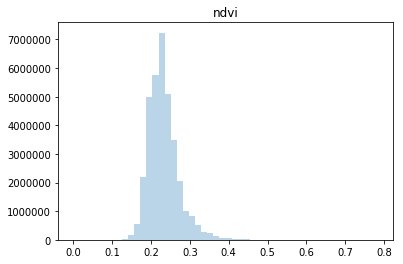

In [18]:
# from 0 to 255
import matplotlib.pyplot as plt
plt.figure()
plt.hist(ndvi[~badii].flatten(), bins=50, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled')
plt.title('ndvi')
plt.show()

In [19]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [23]:
%matplotlib inline

/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


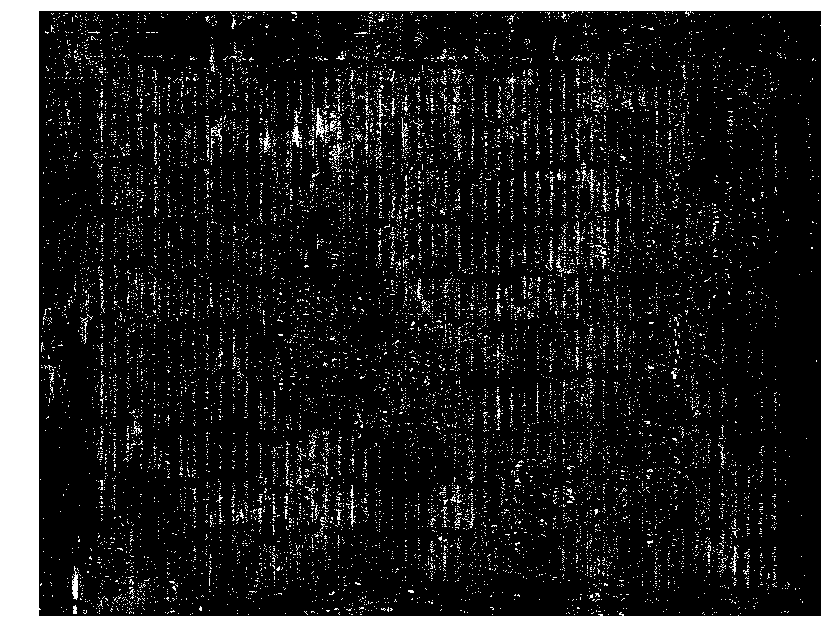

In [24]:
# with a "healthy" clipping applied on the ndvi
healthy_ndvi = 0.3
ndvi_segmented = ndvi > healthy_ndvi
image_show(ndvi_segmented);

/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/skimage/feature/_canny.py:183: RuntimeWarning: invalid value encountered in greater
  eroded_mask = eroded_mask & (magnitude > 0)
/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/skimage/feature/_canny.py:192: RuntimeWarning: invalid value encountered in greater_equal
  pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/skimage/feature/_canny.py:193: RuntimeWarning: invalid value encountered in less_equal
  pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/skimage/feature/_canny.py:193: RuntimeWarning: invalid value encountered in greater_equal
  pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/skimage/feature/_canny.py:203: Runt

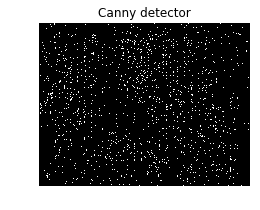

In [25]:
## try edge-based segmentation
from skimage.feature import canny
from skimage.morphology import watershed
from skimage.feature import peak_local_max

edges = canny(ndvi)   # /255.)
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(edges, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('Canny detector')

In [26]:
del ndvi_segmented, edges

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


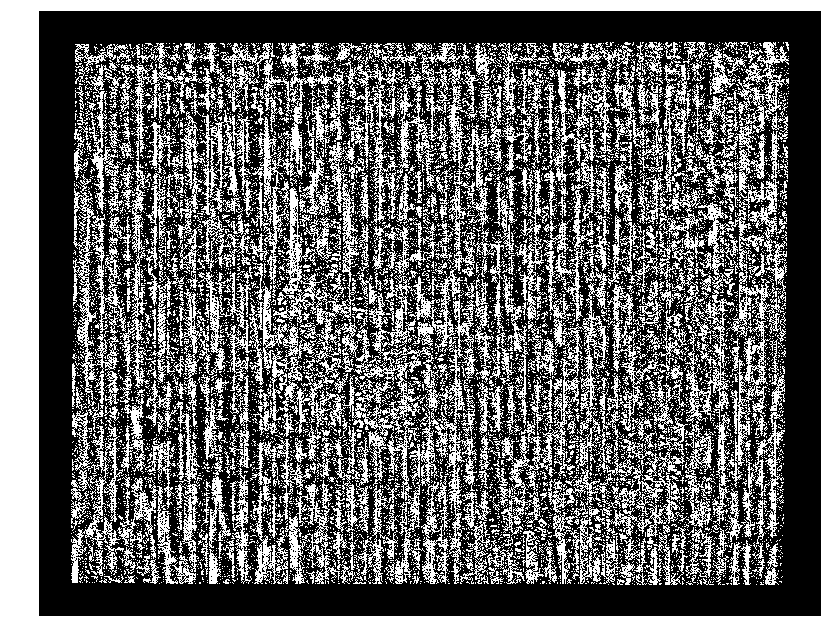

In [27]:
ndvi_threshold = filters.threshold_local(ndvi, block_size=401) #, offset=10) 
print(ndvi_threshold)
image_show(ndvi > ndvi_threshold);

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


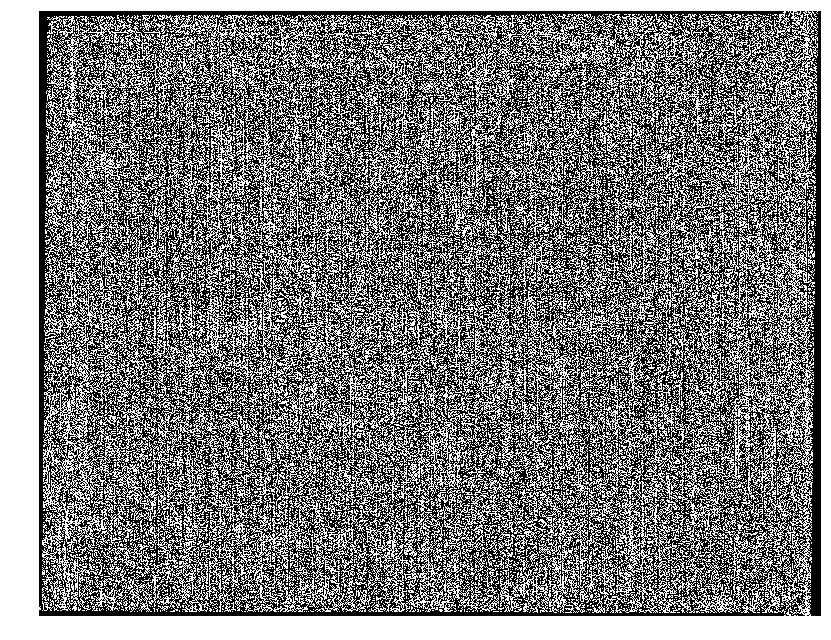

In [29]:
ndvi_threshold = filters.threshold_local(ndvi, block_size=39) #, offset=10) 
print(ndvi_threshold)
image_show(ndvi > ndvi_threshold);

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


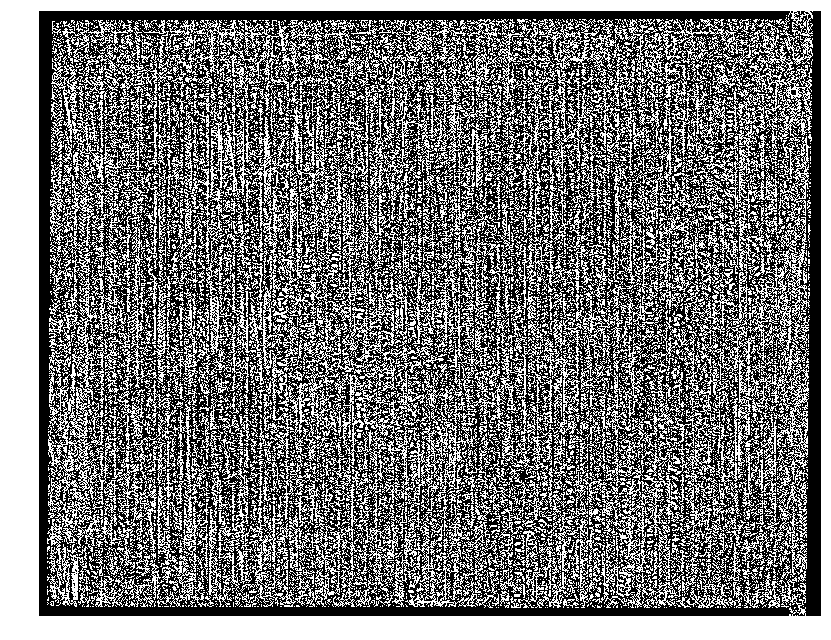

In [30]:
ndvi_threshold = filters.threshold_local(ndvi, block_size=101) #, offset=10) 
image_show(ndvi > ndvi_threshold);

/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


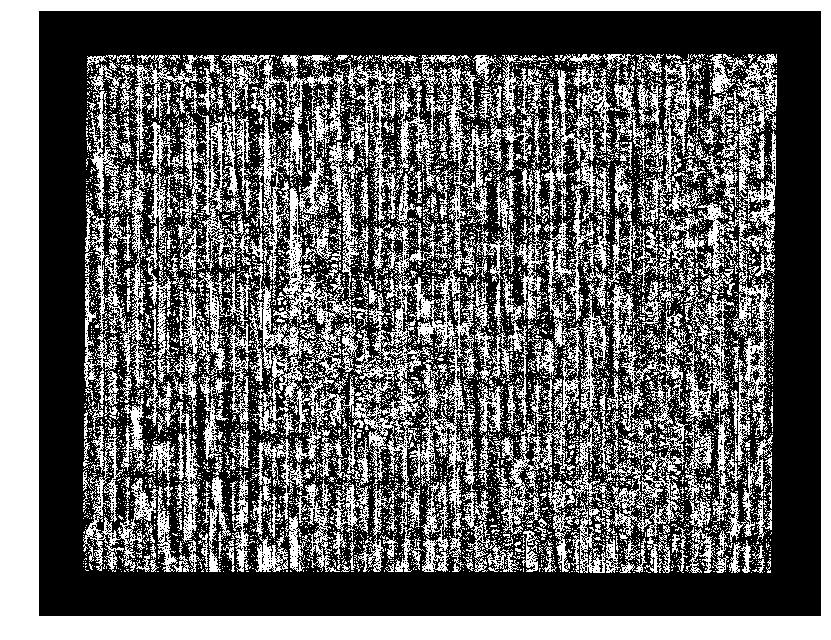

In [31]:
ndvi_threshold = filters.threshold_local(ndvi, block_size=555) #, offset=10) 
image_show(ndvi > ndvi_threshold);

## Population Map
### get a boolean mask on the train field based on the ground truth

In [51]:
# get 2D array of 1 and 0, 1 for plant, 0 for not plant from ground truth
def bool_mask_truth(datasetTrain, truthf):
    train_img1 = datasetTrain.read(1)
    plant_bool = np.zeros_like(train_img1)
    
    import fiona
    with fiona.open(truthf, "r") as shfile:
        features = [feature['geometry'] for feature in shfile]

    for i in features:
        # get the x,y pix position of each plant pos
        py, px = datasetTrain.index(*i['coordinates'])
        # print('Pixel Y, X coords: {}, {}'.format(py, px))
        plant_bool[py, px] = 1.0
    plant_bool = plant_bool.astype(int)
    return plant_bool
        
plant_bool = bool_mask_truth(datasetTrain, truthf)
data_mask = plant_bool == 1
data = np.ma.array(plant_bool, mask=data_mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


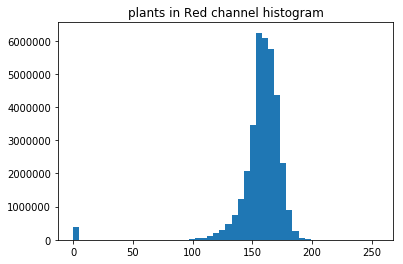

In [36]:
plt.hist(red.flatten(), bins=50)
plt.title('plants in Red channel histogram')
plt.show();

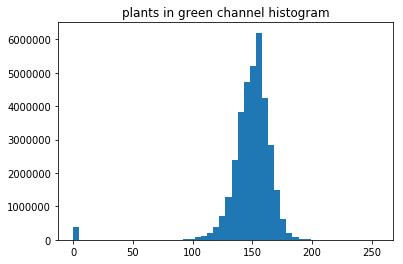

In [43]:
plt.hist(datasetTrain.read(2).flatten(), bins=50)
plt.title('plants in green channel histogram')
plt.show();

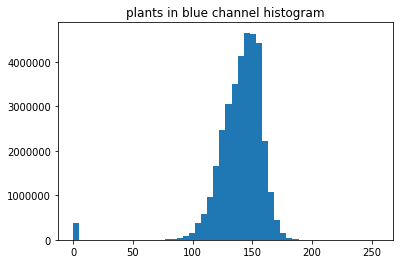

In [44]:
plt.hist(datasetTrain.read(3).flatten(), bins=50)
plt.title('plants in blue channel histogram')
plt.show();

In [ ]:
plt.hist(datasetTrain.read(4).flatten(), bins=50)
plt.title('plants in NIR channel histogram')
plt.show();

(-0.5, 6734.5, 5213.5, -0.5)

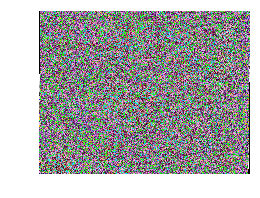

In [54]:
# Each RNB band is convolvedwith a gaussian filter and then subtracted 
rnb = np.dstack((red, datasetTrain.read(3), nir))
rnb_dog = rnb - ndi.gaussian_filter(rnb, 3) # difference of gaussians

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(rnb_dog, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')

### get ourselves oriented by looking at the geospatial coord system of the TIF file

In [36]:
from osgeo import gdal, osr
ds = gdal.Open(trainf)
print(ds.GetProjection())
cols = ds.RasterXSize; print('# of columns:',cols)
rows = ds.RasterYSize; print('# of rows:',rows)

# left-most X coord, W-E pixel res, rotation (0 if N-up),
# upper Y coor, rotation, N-S pix resolution
geo_transform = ds.GetGeoTransform()
# https://download.osgeo.org/gdal/workshop/foss4ge2015/workshop_gdal.pdf
xMin, dx, b, yMax, d, dy = ds.GetGeoTransform()
if dy < 0: 
    print("origin of image is upper left corner")

print(dx, dy)    # in deg
print(xMin, yMax)

def get_raster_extents(gt, ds):
    width = ds.RasterXSize
    height = ds.RasterYSize
    
    print('Upper Left Corner:', gdal.ApplyGeoTransform(gt, 0, 0))
    print('Upper Right Corner:', gdal.ApplyGeoTransform(gt, width, 0))
    print('Lower Left Corner:', gdal.ApplyGeoTransform(gt,0, height))
    print('Lower Right Corner:',gdal.ApplyGeoTransform(gt, width, height))
    print('Center:', gdal.ApplyGeoTransform(gt, width/2, height/2))

    # similarly, 
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]  
    maxx = gt[0] + width*gt[1] + height*gt[2]  
    maxy = gt[3]
    print(minx, maxx, miny, maxy)
    return minx, maxx, miny, maxy

minx, maxx, miny, maxy = get_raster_extents(geo_transform, ds)          

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
# of columns: 6735
# of rows: 5214
origin of image is upper left corner
7.23197880395e-08 -7.23197880395e-08
-89.8129073071484 35.12562160893812
Upper Left Corner: [-89.8129073071484, 35.12562160893812]
Upper Right Corner: [-89.81242023337595, 35.12562160893812]
Lower Left Corner: [-89.8129073071484, 35.12524453356328]
Lower Right Corner: [-89.81242023337595, 35.12524453356328]
Center: [-89.81266377026218, 35.1254330712507]


In [37]:
from math import *

def dist_btw_pair_latlon(lon0, lat0, lon1, lat1):
    d2r =0.0174532925199433
    dlon = (lon1 - lon0)*d2r
    dlat = (lat1 - lat0)*d2r
    
    a = (sin(dlat/2))**2 + cos(lat0) * cos(lat1) * (sin(dlon/2))**2 
    c = 2 * atan2( sqrt(a), sqrt(1-a) ) 
    RE = 6378.1e3     # m
    d = RE * c     
    return d

### How big does the train field cover in physical unit

In [13]:
yyyrange_m = dist_btw_pair_latlon(minx, miny,  minx, maxy)
xxxrange_m = dist_btw_pair_latlon(minx, miny,  maxx, miny)
print(xxxrange_m)
print(yyyrange_m)

# for small lat range
mPerPixX = xxxrange_m / cols
mPerPixY = yyyrange_m / rows

45.7147194933329
41.975595212724556


In [15]:
# get pixel unit
ppp = ds.GetProjection()
starti = ppp.find('UNIT')
if ppp[starti+6: starti+12] == 'degree':
    print("Map in real world units...")
    
    
def pixel2coord(geo_transform, x, y):
    """
    Returns global coordinates from pixel x, y coords
    """
    xoff, a, b, yoff, d, e = geo_transform

    xp = a * x + b * y + xoff
    yp = d * x + e * y + yoff
    return (xp, yp)


def get_latlon_axeslab(geo_transform, x, y):
    lat, lon = pixel2coord(geo_transform, x, y)
    return lat, lon
    



Map in real world units...


In [44]:
# get plant/ac 
def compute_plperac_ground_truth(plant_bool, xxxrange_m, yyyrange_m, geo_transform):
    """ 
        determine the number of plants per acre from the ground truth 
        
    Parameters
    ---------
    plant_bool: array of bools
        1 meaning it contains a plant, 0 else
        
    xxxrange_m: float
        range in meters of the field in x-dir
        
    yyyrange_m: float
        range in meters of the field in y-dir
        
    Returns
    -------
    new: array
        containing number of plants per acre, which is the area of each pixel
         
    """
    
    ac2sqm = 4046.86
    p = np.sqrt(ac2sqm)
    delx = p
    dely = p
   
    # assuming in meters
    xmin, xmax, ymin, ymax = 0, xxxrange_m, 0, yyyrange_m
    
    ny = int(np.ceil(np.abs(ymax - ymin)/p))
    nx = int(np.ceil(np.abs(xmax - xmin)/p))
    new = np.zeros((ny, nx))
    # print(ny, nx)
    
    # number of elements in original image w/in p [meters]
    cols = plant_bool.shape[1]
    rows = plant_bool.shape[0]
    mPerPixX, mPerPixY = xxxrange_m / cols, yyyrange_m / rows
    nnx = int(p / mPerPixX)
    nny = int(p / mPerPixY)
    
    xticklab = []
    yticklab = []
    for k in range(nx):
        for l in range(ny):
            new[l, k] = plant_bool[nny*l: nny*(l+1), nnx*k: nnx*(k+1)].sum()
            
#     # for getting lat lon labeling
#     lat, lon = get_latlon_axeslab(geo_transform, nnx*0, nny*0)
#     xticklab.append(lon)
#     yticklab.append(lat)
#     for k in range(nx):
#         l = 0
#         lat, lon = get_latlon_axeslab(geo_transform, nnx*k, nny*l)
#         print(lat, lon)
#         yticklab.append(lat)
# 
#     for l in range(ny):
#         k = 0
#         lat, lon = get_latlon_axeslab(geo_transform, nnx*k, nny*l)
#         xticklab.append(lon)
                        
    return new

In [29]:
def plot_plant_pop_map(plant_pop_arr, coord=None):
    if plant_pop_arr.ndim == 2:
        fig, ax = plt.subplots()
        plt.imshow(plant_pop_arr)
        plt.colorbar()
        
        if coord is not None: 
            raise NotImplementedError
        plt.title('Plant population map [# plants/ac]')
        plt.show();

In [45]:
# Make a plant population map
plant_pop_arr = np.squeeze(compute_plperac_ground_truth(plant_bool, xxxrange_m, yyyrange_m, geo_transform))
plot_plant_pop_map(plant_pop_arr)